## Part 2: Image Classification - Buildings or Forest

### Pre-Processing of Data

In [21]:
# Importing packages
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import cv2 
import os 
from random import shuffle 
from tqdm import tqdm 
from PIL import Image

import warnings
warnings.filterwarnings('ignore')
import os

In [22]:
# Loading the dataset
train_buildings = "dataset/seg_train/seg_train/buildings"
train_forest = "dataset/seg_train/seg_train/forest"
test_buildings = "dataset/seg_test/seg_test/buildings"
test_forest = "dataset/seg_test/seg_test/forest"
image_size = 128

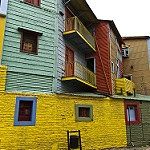

In [23]:
# Image of a Building
Image.open("dataset/seg_train/seg_train/buildings/4.jpg")

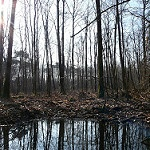

In [24]:
# Image of a Forest
Image.open("dataset/seg_train/seg_train/forest/23.jpg")

100%|█████████████████████████████████████| 2271/2271 [00:01<00:00, 1456.83it/s]


Text(0.5, 1.0, 'Buildings and Forest in GrayScale')

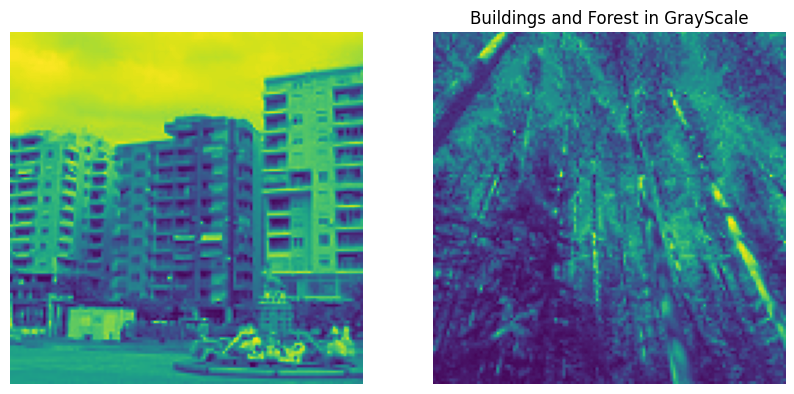

In [25]:
# Exploring the dataset
for image in tqdm(os.listdir(train_buildings)): 
    path = os.path.join(train_buildings, image)
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE) 
    img = cv2.resize(img, (image_size, image_size)).flatten()   
    np_img = np.asarray(img)
    
for image2 in tqdm(os.listdir(train_forest)): 
    path = os.path.join(train_forest, image2)
    img2 = cv2.imread(path, cv2.IMREAD_GRAYSCALE) 
    img2 = cv2.resize(img2, (image_size, image_size)).flatten() 
    np_img2 = np.asarray(img2)

plt.figure(figsize=(10,10))
plt.subplot(1, 2, 1)
plt.imshow(np_img.reshape(image_size, image_size))
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(np_img2.reshape(image_size, image_size))
plt.axis('off')
plt.title("Buildings and Forest in GrayScale")

In [26]:
# Resizing the data
def train_data():
    train_data_buildings = [] 
    train_data_forest = []
    for image1 in tqdm(os.listdir(train_buildings)): 
        path = os.path.join(train_buildings, image1)
        img1 = cv2.imread(path, cv2.IMREAD_GRAYSCALE) 
        img1 = cv2.resize(img1, (image_size, image_size))
        train_data_buildings.append(img1) 
    for image2 in tqdm(os.listdir(train_forest)): 
        path = os.path.join(train_forest, image2)
        img2 = cv2.imread(path, cv2.IMREAD_GRAYSCALE) 
        img2 = cv2.resize(img2, (image_size, image_size))
        train_data_forest.append(img2) 
    
    train_data = np.concatenate((np.asarray(train_data_buildings),np.asarray(train_data_forest)),axis=0)
    return train_data

In [27]:
# Resizing the data
def test_data():
    test_data_buildings = [] 
    test_data_forest = []
    for image1 in tqdm(os.listdir(test_buildings)): 
        path = os.path.join(test_buildings, image1)
        img1 = cv2.imread(path, cv2.IMREAD_GRAYSCALE) 
        img1 = cv2.resize(img1, (image_size, image_size))
        test_data_buildings.append(img1) 
    for image2 in tqdm(os.listdir(test_forest)): 
        path = os.path.join(test_forest, image2)
        img2 = cv2.imread(path, cv2.IMREAD_GRAYSCALE) 
        img2 = cv2.resize(img2, (image_size, image_size))
        test_data_forest.append(img2)
    
    test_data = np.concatenate((np.asarray(test_data_buildings),np.asarray(test_data_forest)),axis=0) 
    return test_data

In [28]:
train_data = train_data() 
test_data = test_data()

100%|███████████████████████████████████████| 474/474 [00:00<00:00, 1662.76it/s]


In [29]:
x_data = np.concatenate((train_data,test_data), axis = 0)
x_data = (x_data-np.min(x_data))/(np.max(x_data)-np.min(x_data))

In [30]:
z1 = np.zeros(2191)
o1 = np.ones(2271)
Y_train = np.concatenate((o1, z1), axis=0)
z = np.zeros(437)
o = np.ones(474)
Y_test = np.concatenate((o, z), axis=0)

In [31]:
y_data = np.concatenate((Y_train,Y_test), axis = 0).reshape(x_data.shape[0],1)

In [32]:
print("X shape: " , x_data.shape)
print("Y shape: " , y_data.shape)

X shape:  (5373, 128, 128)
Y shape:  (5373, 1)


In [33]:
# Splitting the data into test and train
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size = 0.15, random_state = 42)
number_of_train = x_train.shape[0]
number_of_test = x_test.shape[0]
num_px = x_train.shape[2]

In [34]:
# Reshaping the training and test set
x_train_flatten = x_train.reshape(number_of_train, x_train.shape[1]*x_train.shape[2])
x_test_flatten = x_test.reshape(number_of_test, x_test.shape[1]*x_test.shape[2])
print("X train flatten",x_train_flatten.shape)
print("X test flatten",x_test_flatten.shape)

X train flatten (4567, 16384)
X test flatten (806, 16384)


In [35]:
x_train = x_train_flatten.T
x_test = x_test_flatten.T
y_test = y_test.T
y_train = y_train.T

x_train = x_train/255.0
x_test = x_test/255

print("x train: ",x_train.shape)
print("x test: ",x_test.shape)
print("y train: ",y_train.shape)
print("y test: ",y_test.shape)

x train:  (16384, 4567)
x test:  (16384, 806)
y train:  (1, 4567)
y test:  (1, 806)


### A. Logistic Regression Algorithm

In [36]:
# Initializing parameters
def initialize_weights_and_bias(dimension):
    w = np.full((dimension,1),0.01)
    b = 0.0
    return w, b

# Helper functions
def sigmoid(z):
    y_head = 1/(1+np.exp(-z))
    return y_head

# Forward and Backward propagation
def forward_backward_propagation(w,b,x_train,y_train):
    # forward propagation
    z = np.dot(w.T,x_train) + b
    y_head = sigmoid(z)
    loss = -y_train*np.log(y_head)-(1-y_train)*np.log(1-y_head)
    cost = (np.sum(loss))/x_train.shape[1]
    # backward propagation
    derivative_weight = (np.dot(x_train,((y_head-y_train).T)))/x_train.shape[1]
    derivative_bias = np.sum(y_head-y_train)/x_train.shape[1]
    gradients = {"derivative_weight": derivative_weight,"derivative_bias": derivative_bias}
    return cost,gradients

# Optimization
def update(w, b, x_train, y_train, learning_rate, number_of_iterarion):
    cost_list = []
    cost_list2 = []
    index = []
    
    for i in range(number_of_iterarion):
        
        cost,gradients = forward_backward_propagation(w,b,x_train,y_train)
        cost_list.append(cost)
        
        w = w - learning_rate * gradients["derivative_weight"]
        b = b - learning_rate * gradients["derivative_bias"]
        if i % 100 == 0:
            cost_list2.append(cost)
            index.append(i)
            print ("Cost after iteration %i: %f" %(i, cost))
    
    parameters = {"weight": w,"bias": b}
    plt.plot(index,cost_list2)
    plt.xticks(index,rotation='vertical')
    plt.xlabel("Number of Iterarion")
    plt.ylabel("Cost")
    plt.show()
    return parameters, gradients, cost_list

# Predict function
def predict(w,b,x_test):
    
    m = x_test.shape[1]
    Y_prediction = np.zeros((1,m))
    w = w.reshape(x_test.shape[0], 1)
    
    z = sigmoid(np.dot(w.T,x_test)+b)
    
    for i in range(z.shape[1]):
        if z[0,i]<= 0.5:
            Y_prediction[0,i] = 0
        else:
            Y_prediction[0,i] = 1

    return Y_prediction

# Merge all functions into a model
def model(x_train, y_train, x_test, y_test, learning_rate ,  num_iterations):

    dimension =  x_train.shape[0]
    w,b = initialize_weights_and_bias(dimension)

    parameters, gradients, cost_list = update(w, b, x_train, y_train, learning_rate,num_iterations)
    
    w = parameters["weight"]
    b = parameters["bias"]
    
    y_prediction_test = predict(parameters["weight"],parameters["bias"],x_test)
    y_prediction_train = predict(parameters["weight"],parameters["bias"],x_train)
    
    print("Test Accuracy: {} %".format(round(100 - np.mean(np.abs(y_prediction_test - y_test)) * 100,2)))
    print("Train Accuracy: {} %".format(round(100 - np.mean(np.abs(y_prediction_train - y_train)) * 100,2)))
    
    d = {"costs": cost_list,
         "Y_prediction_test": y_prediction_test, 
         "Y_prediction_train" : y_prediction_train, 
         "w" : w, 
         "b" : b,
         "learning_rate" : learning_rate,
         "num_iterations": num_iterations}
    
    return d

Cost after iteration 0: 0.680771
Cost after iteration 100: 0.678461
Cost after iteration 200: 0.676998
Cost after iteration 300: 0.676042
Cost after iteration 400: 0.675391
Cost after iteration 500: 0.674921
Cost after iteration 600: 0.674559
Cost after iteration 700: 0.674262
Cost after iteration 800: 0.674003
Cost after iteration 900: 0.673767
Cost after iteration 1000: 0.673546
Cost after iteration 1100: 0.673332
Cost after iteration 1200: 0.673124
Cost after iteration 1300: 0.672919
Cost after iteration 1400: 0.672716


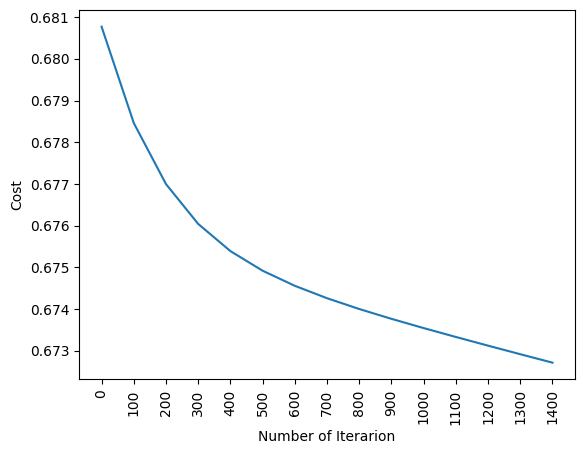

Test Accuracy: 66.5 %
Train Accuracy: 67.09 %


In [37]:
# Main model
d = model(x_train, y_train, x_test, y_test,learning_rate = 0.01, num_iterations = 1500)

In [38]:
# LogisticRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
grid = {"C":np.logspace(-3,3,7),"penalty":["l1","l2"]},
logistic_regression = LogisticRegression(random_state = 42)
log_reg_cv = GridSearchCV(logistic_regression,grid,cv=10)
log_reg_cv.fit(x_train.T,y_train.T)

GridSearchCV(cv=10, estimator=LogisticRegression(random_state=42),
             param_grid=({'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                          'penalty': ['l1', 'l2']},))

In [39]:
print("best hyperparameters: ", log_reg_cv.best_params_)
print("accuracy: ", log_reg_cv.best_score_)

best hyperparameters:  {'C': 10.0, 'penalty': 'l2'}
accuracy:  0.7569426849399209


In [40]:
# Accuracy of the LogisticRegression model
log_reg = LogisticRegression(C=10,penalty="l2",random_state = 42)
log_reg_model = log_reg.fit(x_train.T,y_train.T)
print("test accuracy: {} ".format(log_reg_model.score(x_test.T, y_test.T)))

test accuracy: 0.750620347394541 


### B.  Random Forest Classifier

In [41]:
# RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier

random_forest = RandomForestClassifier(random_state = 42)
random_forest_model = random_forest.fit(x_train.T,y_train.T)

In [42]:
# Accuracy of the RandomForestClassifier
print("test accuracy: {} ".format(random_forest_model.score(x_test.T, y_test.T)))

test accuracy: 0.8213399503722084 


### C.  SVM

In [43]:
# SVM Classifier model
from sklearn.svm import SVC
SVM_clf = SVC(random_state = 42)

# Fitting the SVM Classifier model on training dataset
SVM_clf.fit(x_train.T,y_train.T)

print("Accuracy: {:.3f}".format(SVM_clf.score(x_test.T, y_test.T)))

Accuracy: 0.813


### D. KNN

In [46]:
# KNN Classifier model
from sklearn.neighbors import KNeighborsClassifier

KNN_clf = KNeighborsClassifier(n_neighbors = 7)

# Fitting the KNN Classifier model on training dataset
KNN_clf.fit(x_train.T, y_train.T)

print("Accuracy: {:.3f}".format(KNN_clf.score(x_test.T, y_test.T)))

Accuracy: 0.681


### E. DT

In [47]:
# Decision Tree Classifier model
from sklearn.tree import DecisionTreeClassifier

DT_clf = DecisionTreeClassifier(random_state = 42)

# Fitting the Decision Tree Classifier model on training dataset
DT_clf.fit(x_train.T, y_train.T)

print("Accuracy: {:.3f}".format(DT_clf.score(x_test.T, y_test.T)))

Accuracy: 0.711


### Comparing models

In [49]:
# Comparing accuracy of different models
pd.set_option('display.max_colwidth', None)
models = ["Logistic Regression", "Random Forest", "SVM", "KNN", "Decision Tree"]
accuracy_scores = ["{:.3f}".format(log_reg_cv.score(x_train.T,y_train.T)), "{:.3f}".format(random_forest_model.score(x_test.T, y_test.T)), "{:.3f}".format(SVM_clf.score(x_test.T, y_test.T)), "{:.3f}".format(KNN_clf.score(x_test.T, y_test.T)), "{:.3f}".format(DT_clf.score(x_test.T, y_test.T))]
#param = [DT_clf_gs, KNN_clf_gs, LR_gs, SVM_clf_gs, RF_clf_gs, SGD_clf_gs]
models_comparison_df = pd.DataFrame(
        {'Model': models,
         'Accuracy Score': accuracy_scores
        })

models_comparison_df

,Model,Accuracy Score
0,Logistic Regression,0.766
1,Random Forest,0.821
2,SVM,0.813
3,KNN,0.681
4,Decision Tree,0.711
